In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Load and clean data
df_skaters = pd.read_csv("skaters_1996_2023.csv")
df_skaters = df_skaters[df_skaters['RK'] != 'Rk']

df_skaters.sort_values(['PLAYER', 'POS', 'SEASON'], inplace=True)
df_skaters['PS'] = df_skaters['PS'].astype('float64')

# Define the weights for the past three seasons
weights = {1: 0.5, 2: 0.3, 3: 0.2}

# Define the age adjustment factors (hypothetical)
age_adjustment = {i: 1 - (i - 26) * 0.01 for i in range(18, 50)}

def calculate_weighted_ps(player_data: pd.DataFrame):
    # Calculate weighted point shares based on past three seasons
    weighted_ps = sum(weights[i] * player_data['PS'].shift(i).fillna(player_data['PS']) for i in weights)
    return weighted_ps.set_axis(player_data['SEASON'])

def apply_age_adjustment(player_data: pd.DataFrame):
    # Apply age adjustment factor
    player_data['FORECAST_PS'] *= player_data['AGE'].astype(int).apply(lambda x: age_adjustment.get(x, 1))
    return player_data['FORECAST_PS'].values

def apply_regression(player_data: pd.DataFrame):
    # Apply regression towards the mean
    league_min_reg = min(1, (50 - (len(player_data) + 1)) / 100)
    player_projected_league_average = projected_league_average_ps_per_position[zip(player_data['POS'], player_data['SEASON'])]
    # player_projected_league_average = projected_league_average_ps_per_position[player_data['SEASON']]
    return (1 - league_min_reg) * player_data['FORECAST_PS'].values + (league_min_reg) * player_projected_league_average.values


league_average_ps = df_skaters.groupby(['POS','SEASON'])['PS'].mean().reset_index()
projected_league_average_ps_per_position = league_average_ps.groupby('POS').apply(calculate_weighted_ps)
# league_average_ps = df_skaters.groupby(['SEASON'])['PS'].mean().reset_index()
# projected_league_average_ps_per_position = league_average_ps.groupby('SEASON').apply(calculate_weighted_ps)


In [18]:
df_skaters['FORECAST_PS'] = np.nan
min_ps = df_skaters['PS'].min()
df_skaters['PS'] += abs(min_ps)  # prevent negatives for scaling, reverted in the end


# Group by player and apply the forecasting system
weighted_ps = df_skaters.groupby('PLAYER').apply(calculate_weighted_ps)
df_skaters['FORECAST_PS'] = weighted_ps.values

# Find the index of the first season for each combination of PLAYER and POS
first_season_indices = df_skaters.groupby(['PLAYER', 'POS'])['SEASON'].idxmin()

# Drop these rows from the DataFrame, since can't predict first season
df_skaters = df_skaters.drop(first_season_indices)


age_adjusted_weighted_ps = df_skaters.groupby('PLAYER').apply(apply_age_adjustment)
df_skaters['FORECAST_PS'] = [year_proj for players in age_adjusted_weighted_ps for year_proj in players]

mean_reg_weighted_ps = df_skaters.groupby('PLAYER').apply(apply_regression)
df_skaters['FORECAST_PS'] = [year_proj for players in mean_reg_weighted_ps for year_proj in players]


df_skaters['PS'] -= abs(min_ps)
df_skaters['FORECAST_PS'] -= abs(min_ps)

df_skaters['DELTA_PS'] = (df_skaters['PS'] - df_skaters['FORECAST_PS'])

df_skaters[['PLAYER','POS','SEASON','PS','FORECAST_PS', 'DELTA_PS']]

,PLAYER,POS,SEASON,PS,FORECAST_PS,DELTA_PS
4977,A.J. Greer,LW,2018,0.2,-0.014468,0.214468
4073,A.J. Greer,LW,2019,0.1,-0.003143,0.103143
2274,A.J. Greer,LW,2021,0.0,0.001483,-0.001483
1287,A.J. Greer,LW,2022,0.2,-0.089595,0.289595
318,A.J. Greer,LW,2023,1.0,0.000426,0.999574
...,...,...,...,...,...,...
18804,Ľuboš Bartečko,LW,2001,1.0,1.584482,-0.584482
17924,Ľuboš Bartečko,LW,2002,2.1,1.134314,0.965686
17037,Ľuboš Bartečko,LW,2003,1.8,1.157767,0.642233
15015,Štefan Ružička,RW,2007,0.5,0.168847,0.331153


count    18652.000000
mean         1.085431
std          1.872430
min         -6.700605
25%         -0.140885
50%          0.610987
75%          2.063521
max         11.036461
Name: DELTA_PS, dtype: float64

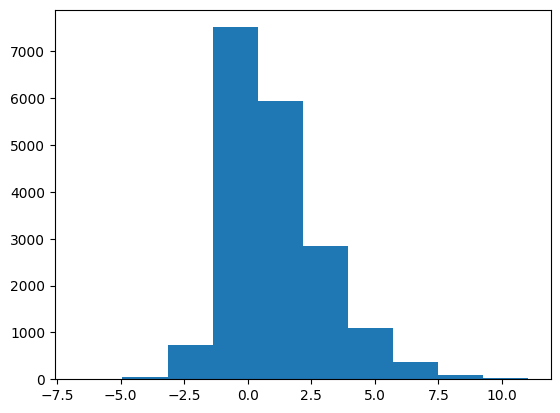

In [19]:
plt.hist(df_skaters['DELTA_PS'])
df_skaters['DELTA_PS'].describe()

In [20]:
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming y_true is the true values and y_pred is the predicted values
y_true = df_skaters['PS']
y_pred = df_skaters['FORECAST_PS']

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}")

# Calculate R^2
r2 = r2_score(y_true, y_pred)
print(f"R^2: {r2}")



MAE: 1.4987849175849242
R^2: 0.4274733966742257
